# Classifier Approach

Testing the idea to build a classifier that directly predicts actions based on observations.

$c: X \rightarrow D$ 

$c(x) = d^*$ with $d^* = \argmin_d \int_\theta p(\theta|x) \mathcal{L}(\theta, d) d\theta$ 


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import matplotlib as mpl
import matplotlib.pyplot as plt
from torch.distributions import Normal

from loss_calibration.classifier import FeedforwardNN, train
from loss_calibration.loss import StepLoss_weighted, BCELoss_weighted
from sbi.utils import BoxUniform
from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi

Define cost of misclassification

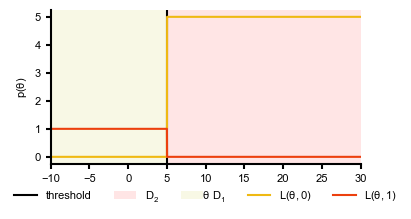

In [3]:
with mpl.rc_context(fname="loss_calibration/.matplotlibrc"):
      threshold = 5.0
      weights = [5.,1.]  
      loss = StepLoss_weighted(weights, threshold=threshold)

      thetas = torch.arange(-10, 30, 0.01)

      plt.figure(figsize=(4,2))
      plt.axvline(x=threshold, color='k', label='threshold')
      plt.axvspan(threshold, 30.5, facecolor='r', alpha=0.1, label=r'$D_2$')
      plt.axvspan(-10.5, threshold, facecolor='y', alpha=0.1, label=r'$D_1$')

      plt.plot(thetas, loss(thetas, 0), color='#EFB913', label=r'$L(\theta, 0)$')
      plt.plot(thetas, loss(thetas, 1), color='#EC400E', label=r'$L(\theta, 1)$')
      
      #plt.xticks([]); plt.yticks([])
      plt.xlabel(r'$\theta$'); plt.ylabel(r'$p(\theta)$')
      plt.xlim(-10,30)
      plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
            fancybox=True, shadow=True, ncol=6)
      #plt.savefig('results/1d_classifier/costs.pdf')
      plt.show()

## Classifier

### Define distributions and sample data

#### Define prior, simulator, posterior

In [4]:
prior = BoxUniform([0.0], [5.0,])

def simulator(theta):
    return 50 + 0.5*theta*(5-theta)**4 + 10 * torch.randn(theta.shape) 

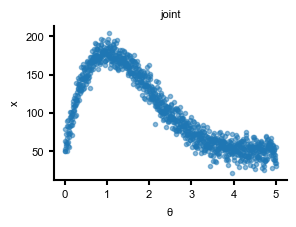

In [5]:
with mpl.rc_context(fname="loss_calibration/.matplotlibrc"):
    plt.figure(figsize=(3,2))
    thetas = torch.linspace(0, 5, 1000)
    plt.scatter(thetas, simulator(thetas), alpha=0.5); 
    plt.xlabel(r'$\theta$'); plt.ylabel('x'); plt.title('joint')
    #plt.savefig('results/1d_classifier/1D_clf_joint.pdf')
    plt.show()

get ground truth posterior

In [94]:
def evaluate_prior(theta):
    return prior.log_prob(theta)
    
def evaluate_likelihood(theta, x): # p(x|theta)
    mean = 50 + 0.5*theta*(5-theta)**4
    noise_dist = Normal(mean, 10)
    return noise_dist.log_prob(x)

def evaluate_joint(theta, x):
    l = evaluate_likelihood(theta, x)
    p = evaluate_prior(theta).unsqueeze(1)
    return l + p

def normalize(values, lower, upper, resolution):
    sum_val = torch.sum(values)
    return sum_val * (upper - lower) / resolution

def gt_posterior(x):
    resolution = 500
    lower = 0.001
    upper = 4.999
    theta_grid = torch.linspace(lower, upper, resolution).unsqueeze(1)
    joint = evaluate_joint(theta_grid, x)
    joint_ = torch.exp(joint)
    norm_constant = normalize(joint_, lower, upper, resolution)
    norm_joint = joint_ / norm_constant
    return norm_joint

In [95]:
xx = gt_posterior(torch.tensor([90]))

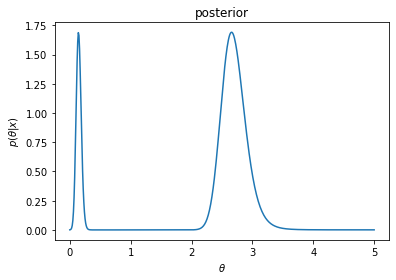

In [97]:
import numpy as np
plt.plot(np.linspace(0, 5, 500), xx)
plt.xlabel(r'$\theta$'); plt.ylabel(r'$p(\theta|x)$'); plt.title('posterior')
plt.show()

#### Set a threshold and weights

In [9]:
weights = [5.,1.]
threshold = 2.0

#### Sample data $(\theta, x) \sim p(\theta)p(x|\theta)$

In [10]:
N = 10000

th_train = prior.sample((N,))
x_train = simulator(th_train)

d_train = (th_train>threshold).float()  #labels 0,1

### Define and train the classifier

In [11]:
clf = FeedforwardNN(1, [16], 1)
clf

FeedforwardNN(
  (input_layer): Linear(in_features=1, out_features=16, bias=True)
  (final_layer): Linear(in_features=16, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [12]:
epochs = 20000
optimizer = torch.optim.Adam(clf.parameters())
criterion = BCELoss_weighted(weights, threshold) # weighted by cost of misclassification

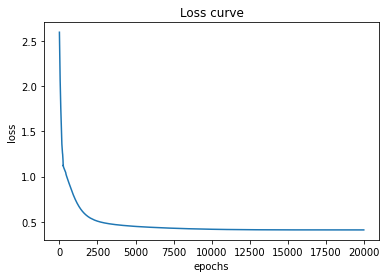

In [13]:
clf, loss_values = train(clf, x_train, th_train, threshold, epochs, criterion, optimizer)

plt.plot(torch.arange(epochs).detach().numpy(), loss_values)
plt.title('Loss curve')
plt.ylabel('loss'); plt.xlabel('epochs')
plt.show()

### Evaluate trained model

In [14]:
N_eval = 2000
th_eval = prior.sample((N_eval,))
x_eval = simulator(th_eval)
d_eval = (th_eval>threshold).float()
preds_eval = clf(x_eval)
preds_eval_bin = (preds_eval>0.5).float()

Accuracy

In [15]:
(sum(preds_eval_bin == d_eval)/N_eval).item()

0.8985000252723694

Show misclassifications

In [16]:
tn = torch.logical_and(preds_eval_bin == 0, d_eval == 0)
tp = torch.logical_and(preds_eval_bin == 1, d_eval == 1)
fn = torch.logical_and(preds_eval_bin == 0, d_eval == 1)
fp = torch.logical_and(preds_eval_bin == 1, d_eval == 0)

Text(0.5, 1.0, 'predictions')

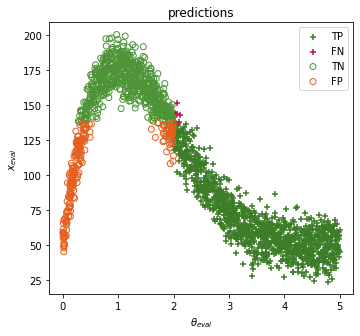

In [17]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.scatter(th_eval[tp], x_eval[tp], c = '#3D7D28', marker= '+', label='TP')
plt.scatter(th_eval[fn], x_eval[fn], c = '#BF1150', marker= '+', label='FN')
plt.scatter(th_eval[tn], x_eval[tn], edgecolors = '#4D9436', marker= 'o', facecolors='none', label='TN')
plt.scatter(th_eval[fp], x_eval[fp], edgecolors = '#E55E1E', marker= 'o', facecolors='none', label='FP')
plt.legend()
plt.xlabel(r'$\theta_{eval}$'); plt.ylabel(r'$x_{eval}$'); plt.title('predictions')

In [18]:
sum(fn), sum(fp)

(tensor([6]), tensor([197]))

In [19]:
# incurred loss
sum(fn) * weights[1] + sum(fp) * weights[0]

tensor([991.])

Show decision boundary

In [20]:
# find decision boundary
x_linspace = torch.linspace(10,210, 1000).unsqueeze(dim=1)
preds_linspace = clf(x_linspace)
idx = (torch.abs(preds_linspace - 0.5)).argmin()

/Users/mgorecki/.virtualenvs/mthesis/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return np.asarray(x, float)


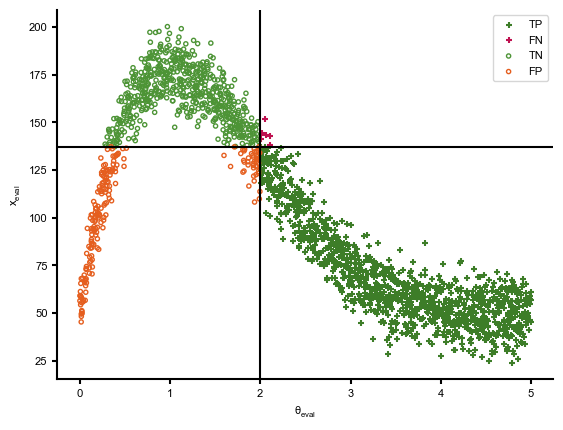

In [21]:
with mpl.rc_context(fname="loss_calibration/.matplotlibrc"):
    #plt.scatter(th_eval[preds_eval>0.5], x_eval[preds_eval>0.5], color='#EC400E', label=r'c(x)=1$', s=2)
    #plt.scatter(th_eval[preds_eval<=0.5], x_eval[preds_eval<=0.5], color='#EFB913', label=r'$c(x)=0$', s=2)
    plt.scatter(th_eval[tp], x_eval[tp], c = '#3D7D28', marker= '+', label='TP', s = 20)
    plt.scatter(th_eval[fn], x_eval[fn], c = '#BF1150', marker= '+', label='FN', s = 20)
    plt.scatter(th_eval[tn], x_eval[tn], edgecolors = '#4D9436', marker= 'o', facecolors='none', label='TN')
    plt.scatter(th_eval[fp], x_eval[fp], edgecolors = '#E55E1E', marker= 'o', facecolors='none', label='FP')
    plt.legend(frameon=True)
    plt.axhline(x_linspace[idx], c = 'k', label = 'decision boundary')
    plt.axvline(threshold, c='k',label = 'threshold')
    plt.xlabel(r'$\theta_{eval}$'); plt.ylabel(r'$x_{eval}$'); #plt.title('classifier: predictions')
    #plt.savefig('results/1d_classifier/1D_clf_predictions.pdf')
    plt.show()

### Compare to classical sbi

In [20]:
# TODO: 1D-example limited to Gaussians, cannot capture bimodal posterior
#       --> higher dimensions needed for usefull comparison?

Train SNPE

In [21]:
num_sim = N

simulator_sbi, prior = prepare_for_sbi(simulator, prior)
inference = SNPE(prior=prior)
sim_thetas, sim_xs = simulate_for_sbi(simulator_sbi, proposal=prior, num_simulations=num_sim)
inference = inference.append_simulations(sim_thetas, sim_xs)
density_estimator = inference.train()
posterior_sbi = inference.build_posterior(density_estimator)

Running 10000 simulations.: 100%|██████████| 10000/10000 [00:00<00:00, 20234.93it/s]
/Users/mgorecki/.virtualenvs/mthesis/lib/python3.9/site-packages/sbi/neural_nets/flow.py:141: UserWarning: In one-dimensional output space, this flow is limited to Gaussians
  warn("In one-dimensional output space, this flow is limited to Gaussians")


 Neural network successfully converged after 51 epochs.

In [22]:
torch.save(posterior_sbi, "results/1d_classifier/posterior_sbi.pt")

Define decision

In [22]:
def d(x_o):
    step_loss = StepLoss_weighted(weights, threshold)
    thetas = torch.linspace(0,5, 1000)
    probs = posterior_sbi.log_prob(thetas.unsqueeze(dim=1), x = x_o).exp()
    # compute expected posterior loss
    l0 = (probs * step_loss(thetas, 0)).sum() 
    l1 = (probs * step_loss(thetas, 1)).sum()
    # choose action that minimized exp. loss
    if l0 < l1:
        return 0.
    else: 
        return 1.

Evaluate

Reuse evaluation data generated for the classifier for comparability

In [23]:
preds_sbi = torch.as_tensor([d(x_o) for x_o in x_eval]).unsqueeze(dim=1)

In [24]:
# find decision boundary
preds_linspace_sbi = torch.as_tensor([d(x) for x in x_linspace]).unsqueeze(dim=1)
idx_sbi = torch.where(preds_linspace_sbi.diff(dim=0))

/Users/mgorecki/.virtualenvs/mthesis/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return np.asarray(x, float)


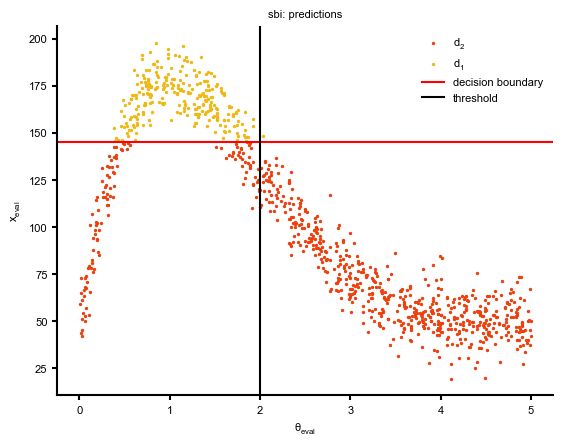

In [25]:
with mpl.rc_context(fname="loss_calibration/.matplotlibrc"):
    plt.scatter(th_eval[preds_sbi.bool()], x_eval[preds_sbi.bool()], color='#EC400E', label=r'$d_2$', s=2)
    plt.scatter(th_eval[(1-preds_sbi).bool()], x_eval[(1-preds_sbi).bool()], color='#EFB913', label=r'$d_1$', s=2)
    plt.axhline(x_linspace[idx_sbi], c = 'r', label = 'decision boundary')
    plt.axvline(threshold, c='k',label = 'threshold')
    plt.xlabel(r'$\theta_{eval}$'); plt.ylabel(r'$x_{eval}$'); plt.title('sbi: predictions')

    plt.legend()
    plt.show()

In [26]:
tn_sbi = torch.logical_and(preds_sbi == 0, d_eval == 0)
tp_sbi = torch.logical_and(preds_sbi == 1, d_eval == 1)
fn_sbi = torch.logical_and(preds_sbi == 0, d_eval == 1)
fp_sbi = torch.logical_and(preds_sbi == 1, d_eval == 0)

Text(0.5, 1.0, 'predictions')

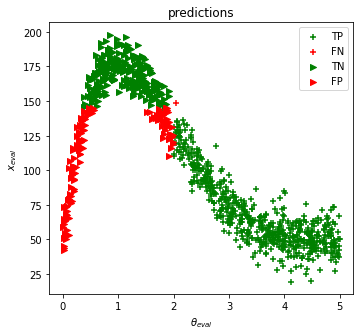

In [27]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.scatter(th_eval[tp_sbi], x_eval[tp_sbi], c = 'g', marker= '+', label='TP')
plt.scatter(th_eval[fn_sbi], x_eval[fn_sbi], c = 'r', marker= '+', label='FN')
plt.scatter(th_eval[tn_sbi], x_eval[tn_sbi], c = 'g', marker= '>', label='TN')
plt.scatter(th_eval[fp_sbi], x_eval[fp_sbi], c = 'r', marker= '>', label='FP')
plt.legend()
plt.xlabel(r'$\theta_{eval}$'); plt.ylabel(r'$x_{eval}$'); plt.title('predictions')

In [28]:
sum(fn_sbi), sum(fp_sbi)

(tensor([1]), tensor([127]))

In [29]:
# incurred loss
sum(fn_sbi) * weights[1] + sum(fp_sbi) * weights[0]

tensor([636.])

### Compute posterior ratios

In [98]:
#does c converge to mean ratio? 
# 
def evaluate_loss(thetas, weights = [5.,1.], T = 2.0):
    loss = StepLoss_weighted(weights, threshold=T)
    loss_fn = loss(thetas, 0)
    loss_fp = loss(thetas, 1)
    return loss_fn, loss_fp

def posterior_ratio(x):
    resolution = 500
    lower = 0.001
    upper = 4.999
    theta_grid = torch.linspace(lower, upper, resolution).unsqueeze(1)
    loss_fn, loss_fp = evaluate_loss(theta_grid) #default parameters
    joint = evaluate_joint(theta_grid, x)
    joint_ = torch.exp(joint)
    norm_constant = normalize(joint_, lower, upper, resolution)
    norm_joint = joint_ / norm_constant
    return (norm_joint * loss_fp * (upper - lower)/resolution).sum()/(norm_joint * loss_fn * (upper - lower)/resolution).sum() 

In [99]:
ratios = torch.as_tensor([posterior_ratio(x) for x in x_train])
# not necessarily in [0,1] !!